In [1]:
from astropy.io import fits
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from winterdrp_offline.utils import plot_image, write_image, get_table_from_ldac
from winterdrp_offline.image_operations import median_combine_images, normalize_and_median_combine_images, split_data_into_channels, merge_channels_into_data
from winterdrp_offline.astrometry import get_astrometry_header_from_scamped_file
from winterdrp_offline.sextractor import run_sextractor
from winterdrp_offline.scamp import get_tmass_gaia_catalog_for_image
from winterdrp_offline.photcal import xmatch_img_ref_cats, calculate_zeropoint_outlier_rejection
import astropy.units as u
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.background import Background2D

Important: Gaia archive will be intermittently unavailable due to scheduled maintenance on Thursday, the 20th of March, from 11:00 to 11:30.


In [2]:
# Set up the directories
base_dir = Path.home() / "Data/observing/winter/"

night = "20250220_CNLC"
night = "20250220_CMFNLC"

target_dir = base_dir / night / "final"

out_dir = target_dir.parent / "crosscheck"
out_dir.mkdir(exist_ok=True)
# print(base_dir)
# name = 'ZTF25aadlqhw'
# night = '20250220'
# boardid = 4

# target_dir = base_dir.joinpath(f'{name}/{night}/{boardid}/')

In [3]:
raw_list = list(target_dir.glob("*0.fits"))
print(f"Found {len(raw_list)} raw files in {target_dir}")

Found 8 raw files in /Users/rdstein/Data/observing/winter/20250220_CMFNLC/final


Loading /Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-072926-636_mef_4_0_0.fits
(1096, 1984)
(16, 16)


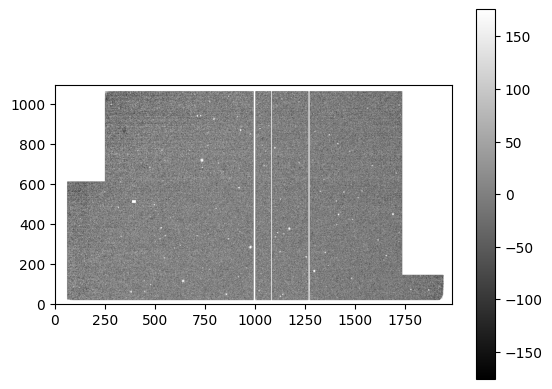

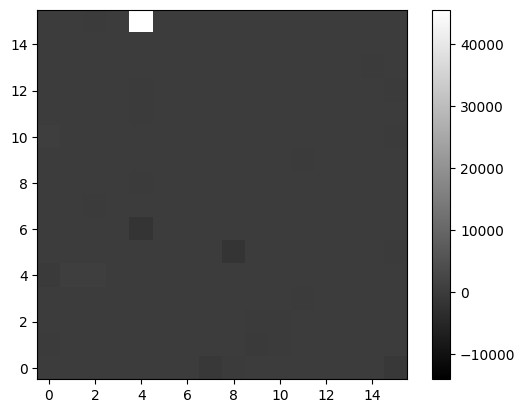

In [4]:
# Load a raw_unpacked file
img_file = raw_list[0]
print(f"Loading {img_file}")
raw_img = fits.getdata(target_dir.joinpath('raw_unpacked', img_file))
from astropy.visualization import ImageNormalize
norm = ImageNormalize(vmin=12000, vmax = 40000)
plot_image(raw_img)

print(raw_img.shape)

roi_center = [312, 1215]
roi_width = 16
roi_height = 16
roi_coords = [roi_center[0] - roi_height//2, roi_center[0] + roi_height//2, roi_center[1] - roi_width//2, roi_center[1] + roi_width//2]
roi = raw_img[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
# astropy visualization norm:
norm = ImageNormalize(vmin=np.nanmin(raw_img), vmax = np.nanmax(raw_img))
plot_image(roi, norm=norm)
print(roi.shape)

shape of channels: (8, 4)
norm: <astropy.visualization.mpl_normalize.ImageNormalize object at 0x12429ba70>


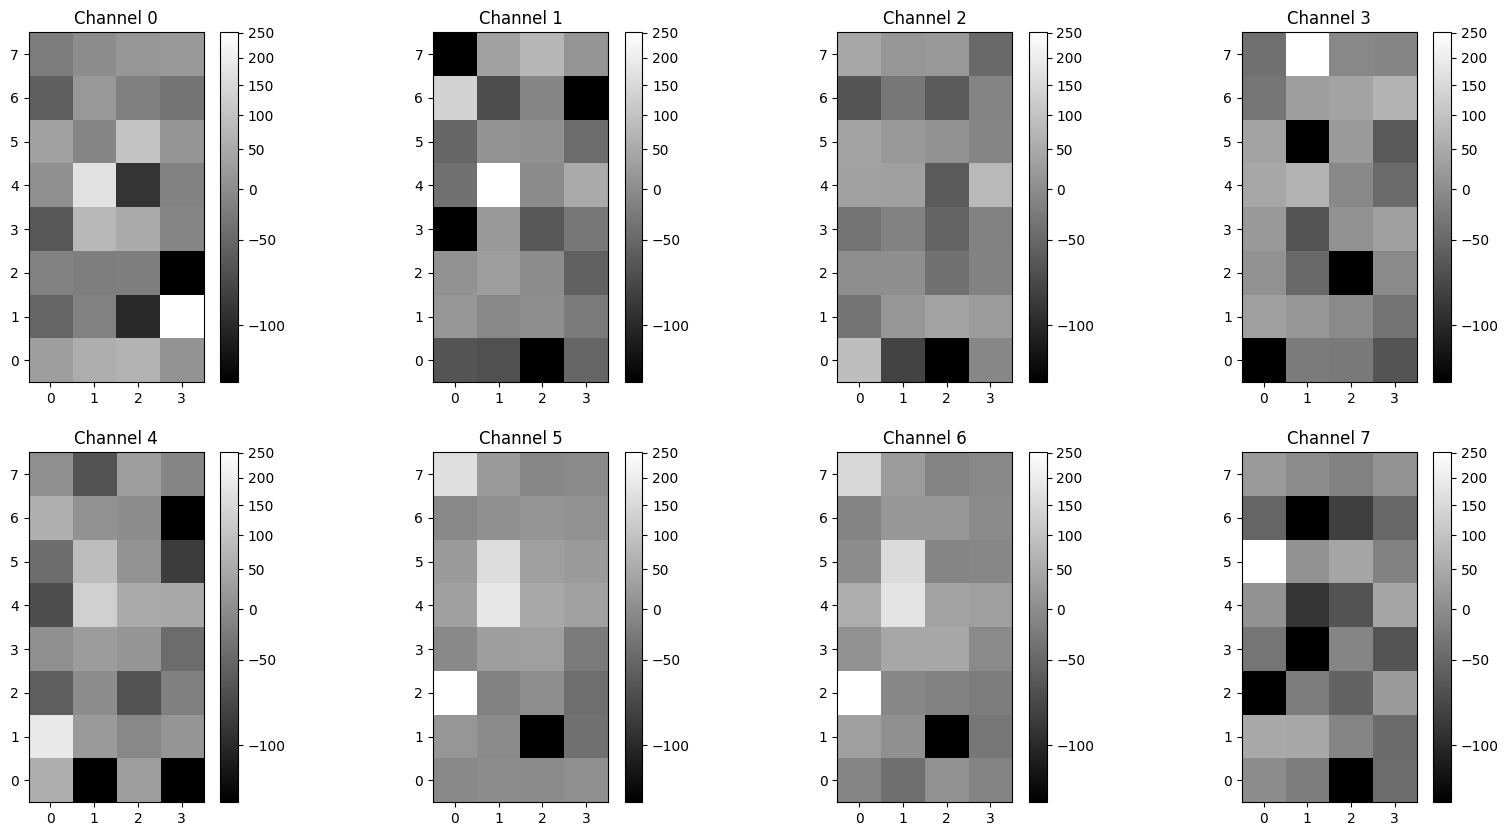

In [5]:
# Split the data up into channels
channels = split_data_into_channels(roi)
print(f"shape of channels: {channels[0].shape}")

# plot all the 8 channels. use the same color scale
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    # if it's the first image, grab the normalization 
    if i==0:
        ax, norm = plot_image(channels[i], ax=ax, return_norm=True, norm = "zscale")
        print(f"norm: {norm}")
    else:
        plot_image(channels[i], ax=ax, norm=norm)
    ax.set_title(f"Channel {i}")
    

plt.show()




In [6]:
# Run sextractor on the skysubtracted image. With regions=True, a regions file
# with all detected sources is written in the target directory.

def get_xmatch_catalog(path: Path):
    image_catalog = get_table_from_ldac(path)
    image_catalog = image_catalog[(image_catalog['MAG_AUTO'] < 99) & (image_catalog['MAG_PSF'] < 99) & (image_catalog['FLAGS']==0) & (image_catalog['FWHM_WORLD']<4.0/3600.0)]
    print(f"Found {len(image_catalog)} good sources in the catalog")

    ref_cat = get_table_from_ldac(path.with_suffix(".local.cat"))
    print(f"Found {len(ref_cat)} good sources in the ref catalog")

    xmatch_cat, xmatch_ref_cat = xmatch_img_ref_cats(image_catalog, ref_cat, xmatch_radius_arcsec=2)
    print(f"Found {len(xmatch_cat)} matched sources")

    return xmatch_cat, xmatch_ref_cat

def get_all_xmatch_cats(parent_dir: Path):
    res = dict()
    cats = list(parent_dir.glob("WINTER*0.cat"))
    for cat in cats:
        res[cat.name] = get_xmatch_catalog(cat)

    return res
    
# catname = run_sextractor(skysub_scamped_filename, weightimg=None, regions=True)

In [7]:
all_xmatch = get_all_xmatch_cats(target_dir.parent / "phot")

Found 1519 good sources in the catalog
Found 191 good sources in the ref catalog
Found 51 matched sources
Found 382 good sources in the catalog
Found 192 good sources in the ref catalog
Found 82 matched sources
Found 1402 good sources in the catalog
Found 195 good sources in the ref catalog
Found 48 matched sources
Found 448 good sources in the catalog
Found 200 good sources in the ref catalog
Found 75 matched sources
Found 273 good sources in the catalog
Found 194 good sources in the ref catalog
Found 80 matched sources
Found 1445 good sources in the catalog


Found 191 good sources in the ref catalog
Found 55 matched sources
Found 156 good sources in the catalog
Found 193 good sources in the ref catalog
Found 71 matched sources
Found 367 good sources in the catalog
Found 200 good sources in the ref catalog
Found 76 matched sources


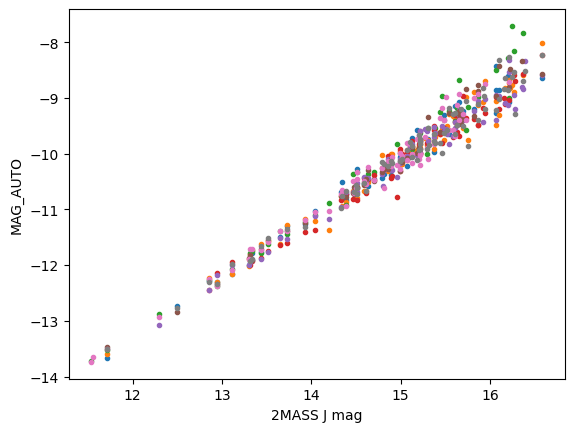

In [8]:
for (cat, ref) in all_xmatch.values():
    plt.plot(ref['j_m'], cat['MAG_AUTO'], '.')
# plt.plot([13., 16.], np.array([-11.5, -8.])-0.35, linestyle=":", color="k") 
plt.ylabel('MAG_AUTO')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "scatter_auto.pdf")

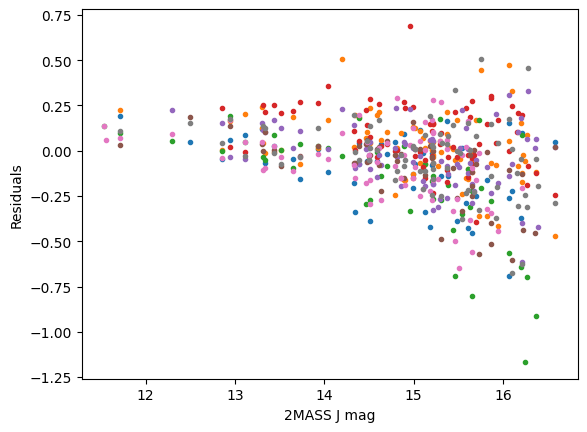

In [9]:
res_df = []

for (cat, ref) in all_xmatch.values():
    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(cat['MAG_AUTO'], ref['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = ref['j_m'] - cat['MAG_AUTO'] - zp
    plt.plot(ref['j_m'], residuals, '.')
    res_df.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars
    })

res_df = pd.DataFrame(res_df)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_auto.pdf")

Median: -0.01, std: 0.21 
 ZP: 25.13, zpstd 0.05, nstars: 240


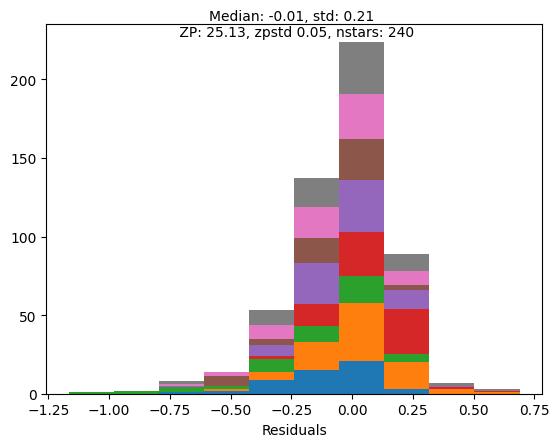

In [10]:
plt.hist(res_df["residuals"], stacked=True,)
all_residuals = [x for y in res_df["residuals"]for x in y]

txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df["zp"].median():.2f}, zpstd {res_df["zpstd"].median():.2f}, nstars: {res_df["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_auto.pdf",
    bbox_inches="tight",
)

In [11]:
# Our goal is to improve this plot.

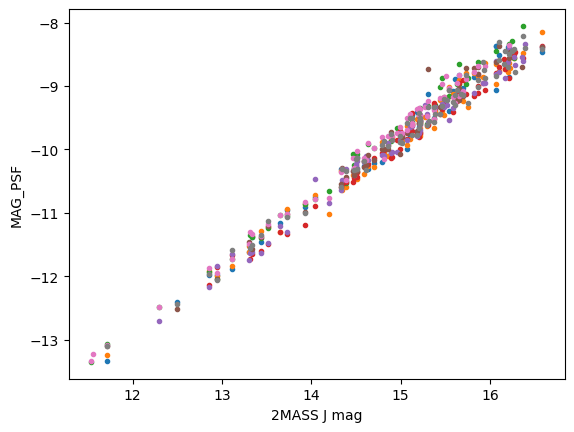

In [12]:
for (cat, ref) in all_xmatch.values():
    plt.plot(ref['j_m'], cat['MAG_PSF'], '.')
# plt.plot([13., 16.], np.array([-11.5, -8.])-0.1, linestyle=":", color="k") 
plt.ylabel('MAG_PSF')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "scatter_psf.pdf")

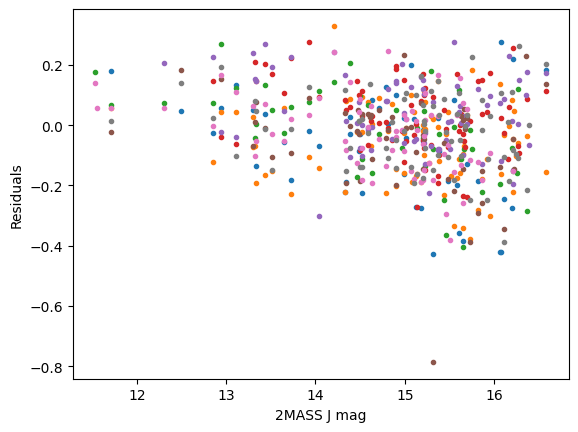

In [13]:
res_df_psf = []

for (cat, ref) in all_xmatch.values():
    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(cat['MAG_PSF'], ref['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = ref['j_m'] - cat['MAG_PSF'] - zp
    plt.plot(ref['j_m'], residuals, '.')
    res_df_psf.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars
    })

res_df_psf = pd.DataFrame(res_df_psf)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_psf.pdf")

Median: -0.01, std: 0.14 
 ZP: 24.82, zpstd 0.05, nstars: 260


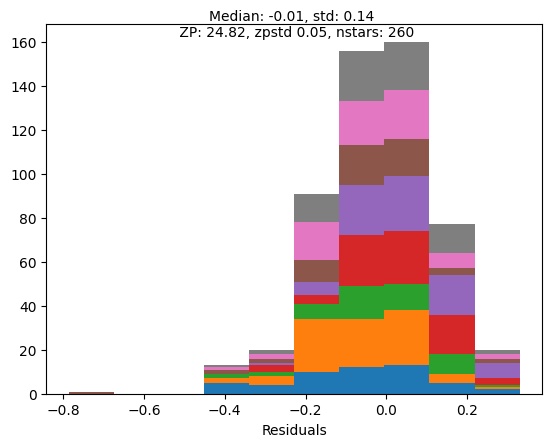

In [14]:
plt.hist(res_df_psf["residuals"], stacked=True)
all_residuals = [x for y in res_df_psf["residuals"] for x in y]
txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_psf["zp"].median():.2f}, zpstd {res_df_psf["zpstd"].median():.2f}, nstars: {res_df_psf["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_psf.pdf",
    bbox_inches="tight",
)

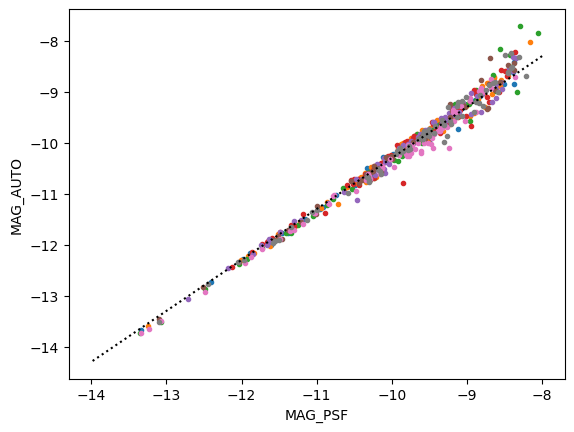

In [15]:
for (cat, ref) in all_xmatch.values():
    plt.plot(cat['MAG_PSF'], cat['MAG_AUTO'], '.')
plt.plot([-8., -14.], np.array([-8., -14.])-0.3, linestyle=":", color="k") 
plt.xlabel("MAG_PSF")
plt.ylabel("MAG_AUTO")
plt.savefig(out_dir / "auto_psf.pdf")

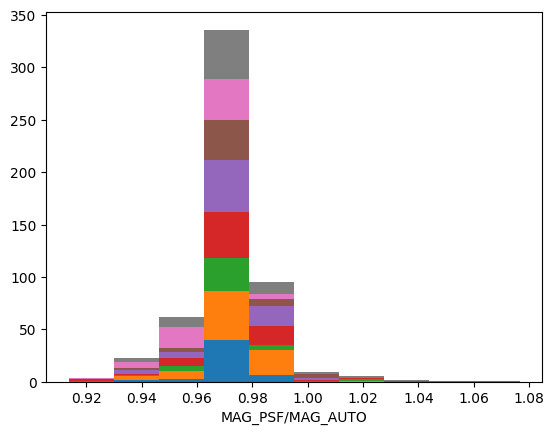

In [16]:
ratios = []
for (cat, ref) in all_xmatch.values():
    ratios.append(cat['MAG_PSF']/cat['MAG_AUTO'])
plt.hist(ratios, stacked=True)
plt.xlabel("MAG_PSF/MAG_AUTO")
plt.savefig(out_dir / "auto_psf_hist.pdf")

In [17]:
from astropy.coordinates import SkyCoord
from astropy import units as u

def get_catalog_mags(crd: SkyCoord, cat, colname: str = 'MAG_AUTO', errcolname: str = 'MAGERR_AUTO'):
    cat_crds = SkyCoord(cat['ALPHAWIN_J2000'], cat['DELTAWIN_J2000'], unit=u.deg)
    idx, sep, _ = crd.match_to_catalog_sky(cat_crds)
    return cat[idx][colname], cat[idx][errcolname], cat[idx][colname.replace('MAG', 'FLUX')], cat[idx][errcolname.replace('MAG', 'FLUX')], cat[idx]['XWIN_IMAGE'], cat[idx]['YWIN_IMAGE'], sep.to(u.arcsec).value

def get_catalog_mags_from_list(crds, catlist, colname: str = 'MAG_AUTO', errcolname: str = 'MAGERR_AUTO'):
    mags = []
    magerrs = []
    fluxes = []
    fluxerrs = []
    xs, ys = [], []
    seps = []
    for cat in catlist:
        mag, magerr, flux, fluxerr, x, y, sep = get_catalog_mags(crds, cat=cat, colname=colname, errcolname=errcolname)
        mags.append(mag)
        magerrs.append(magerr)
        fluxes.append(flux)
        fluxerrs.append(fluxerr)
        xs.append(x)
        ys.append(y)
        seps.append(sep)
    mags = np.array(mags)
    magerrs = np.array(magerrs)
    fluxes = np.array(fluxes)
    fluxerrs = np.array(fluxerrs)
    xs = np.array(xs)
    ys = np.array(ys)
    return mags, magerrs, fluxes, fluxerrs, xs, ys, seps

In [18]:
cats = [x for x, _ in all_xmatch.values()]
ref_cat = ref

In [19]:
bright_ref_cat = ref_cat
# bright_ref_cat = bright_ref_cat[(bright_ref_cat['j_m']<14) & (bright_ref_cat['j_m']>13)]
bright_ref_cat_crds = SkyCoord(ra=bright_ref_cat['ra'], dec=bright_ref_cat['dec'], unit=(u.deg, u.deg))

In [20]:
bright_ref_cat

RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,phot_bp_mean_mag,FRP,e_FRP,phot_rp_mean_mag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,[Fe/H],Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,2MASS,RAVE6,RAJ2000_1,DEJ2000_1,RAJ2000_2,DEJ2000_2,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,Rflg,Bflg,Cflg,Xflg,Aflg,ra,dec,magnitude,magnitude_err,ra_errdeg,dec_errdeg
deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg,deg,deg,mag,mag,mag,mag,mag,mag,,,,,,,deg,deg,mag,mag,mas,mas
float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,bytes12,bytes15,bytes19,int32,bytes10,bytes16,bytes17,bytes21,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes3,bytes3,uint8,uint8,float64,float64,float32,float32,float64,float64
224.44882722474,51.62475915002,1593406173595536256,0.0328,0.0300,0.7306,0.0369,15.487,10.811,0.039,-11.088,0.046,0.974,6784.22837,2.79,16.108616,3469,9.039,16.488062,4744,11.89,15.557623,0.930439,--,--,--,--,0,0,0,1,0,0,0,0,1,1,0,5332.1,4.6192,-0.7589,1050.9144,0.0390,--,169952244488350390,1237661418752573511,--,--,URAT1-709240020,J145747.71+513729.2,8833780,N669010824,--,14574771+5137292,--,224.44874982416,51.62480843164,224.448806,51.624798,15.866,0.040,15.407,0.063,15.440,0.072,AAA,222,111,000,0,0,224.44882722474,51.62475915002,15.866,0.040,0.0000,0.0000
224.47733180716,51.49850409995,1593356936090471296,0.0453,0.0450,0.5624,0.0531,6.967,-5.712,0.055,-3.990,0.066,1.342,4279.41674,2.855,16.608906,1946,9.18,17.115671,3453,11.57,15.902324,1.213347,--,--,--,--,0,0,0,1,0,0,0,0,1,1,0,4601.2,4.3561,-1.3213,1244.3425,0.0418,--,169792244773528860,1237661418752639095,--,--,URAT1-708236110,--,--,N669009874,--,14575456+5129544,--,224.47737258513,51.49852183155,224.477346,51.498466,15.935,0.046,15.352,0.063,15.404,0.074,AAA,222,111,000,0,0,224.47733180716,51.49850409995,15.935,0.046,0.0000,0.0000
224.47845333091,51.54177803361,1593358654077389824,0.0465,0.0496,2.5114,0.0584,75.629,-69.438,0.059,29.968,0.075,1.005,2912.13296,2.093,17.026838,668.2,10.06,18.276218,3411,9.215,15.915723,2.360496,--,--,--,--,0,0,0,1,0,0,0,0,0,1,0,--,--,--,--,--,--,169852244786390733,1237661418752573644,--,--,URAT1-708236111,J145754.87+513230.2,--,N669010218,--,14575493+5132296,--,224.47894953388,51.54164483995,224.478910,51.541580,15.316,0.030,14.795,0.043,14.540,0.044,AAA,222,111,000,0,0,224.47845333091,51.54177803361,15.316,0.030,0.0000,0.0000
224.49989756371,51.55843813460,1593358787220350464,0.0901,0.0954,3.0974,0.1130,28.463,-21.067,0.107,19.139,0.142,0.974,934.90590,1.286,18.260447,152.3,8.363,19.881725,1233,11.33,17.020605,2.861120,--,--,--,--,0,0,0,0,0,0,0,0,1,0,0,3278.3,4.8886,0.0612,318.0313,0.5819,--,169872244999640748,1237661418752639197,--,--,URAT1-708236117,J145759.98+513330.2,--,N669010347,--,14580002+5133300,--,224.50004816740,51.55835307075,224.500098,51.558338,16.107,0.047,15.620,0.067,15.336,0.069,AAA,222,111,000,0,0,224.49989756371,51.55843813460,16.107,0.047,0.0000,0.0000
224.50529047379,51.46705872502,1593356042737290112,0.0483,0.0486,3.5506,0.0550,10.130,-9.177,0.058,4.288,0.069,1.634,5799.74626,5.82,16.278845,1407,6.85,17.467604,6823,8.855,15.162999,2.304604,--,--,--,--,0,0,0,1,0,0,0,0,0,1,0,--,--,--,--,--,--,169762245053321104,1237661418752639121,--,--,URAT1-708236118,J145801.27+512801.4,--,N669009605,--,14580128+5128011,--,224.50535594812,51.46703966903,224.505340,51.466999,14.616,0.024,14.030,0.037,13.769,0.028,AAA,222,111,000,0,0,224.5052

Text(0.5, 0, 'Frame #')

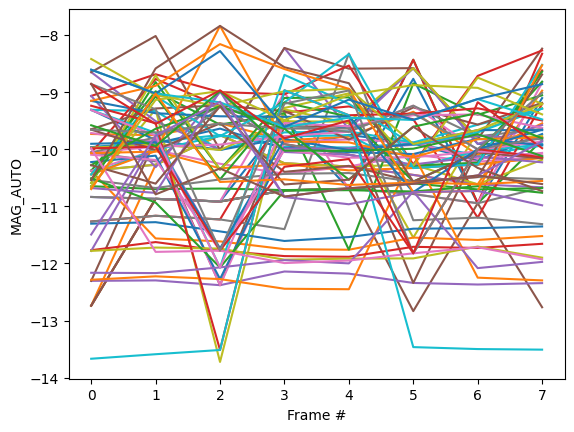

In [21]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats)
plt.plot(mags)
plt.ylabel(r'MAG_AUTO')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (AUTO)')

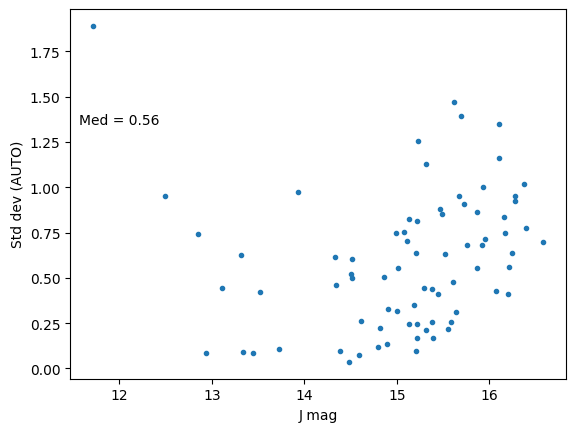

In [22]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (AUTO)')

Text(0.5, 0, 'Frame #')

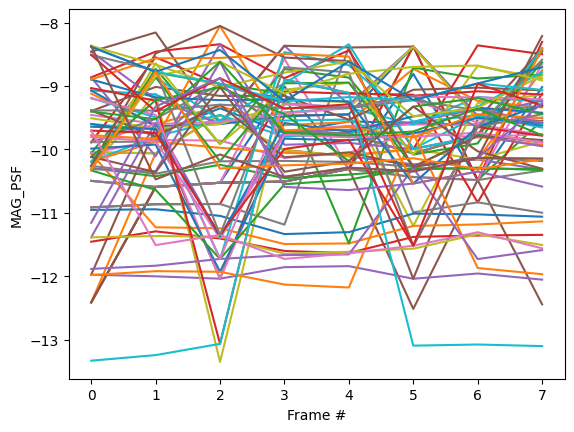

In [23]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, colname="MAG_PSF")
plt.plot(mags)
plt.ylabel(r'MAG_PSF')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (PSF)')

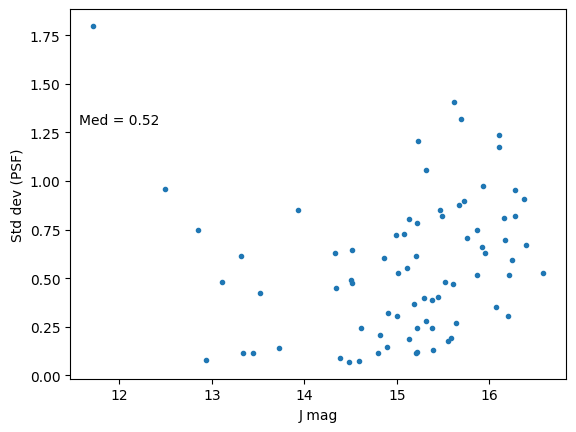

In [24]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (PSF)')

In [25]:
def perform_aperture_photometry_on_coordinates(image, astrometry_image, crds, aper_radius=5, annulus_bkg_in=10, annulus_bkg_out=15, **kwargs):
    """
    Perform aperture photometry on a list of coordinates.
    :param image:
    :param crds:
    :param aper_radius:
    :param annulus_bkg_in:
    :param annulus_bkg_out:
    :return:
    """
    image_data = fits.getdata(image)
    wcs = WCS(fits.getheader(astrometry_image))
    # Convert coordinates to pixel coordinates
    crds = crds.to_pixel(wcs)
    xs = crds[0]
    ys = crds[1]
    apertures = CircularAperture(np.column_stack((xs, ys)), r=aper_radius)
    # annulus_apertures = CircularAnnulus(np.column_stack((xs, ys)), r_in=annulus_bkg_in, r_out=annulus_bkg_out)

    bkg = Background2D(image_data, box_size=(50, 50), filter_size=(3, 3), **kwargs)
    bkg_mean = bkg.background_median
    # bkg_tab = aperture_photometry(image_data, annulus_apertures)

    # annulus_mask = annulus_apertures.to_mask(method='center')
    # annulus_bkg_data = annulus_mask[0].multiply(image_data)
    # annulus_bkg_median = np.nanmedian(annulus_bkg_data[annulus_bkg_data > 0])
    # phot_table_annulus = aperture_photometry(image_data - annulus_bkg_median, apertures)
    # Perform aperture photometry
    phot_table = aperture_photometry(image_data - bkg_mean, apertures, mask=np.isnan(image_data))

    return phot_table # phot_table_annulus

def perform_aperture_photometry_in_multiple_images(image_list, astrometry_image_list, crds, aper_radius=5, annulus_bkg_in=10, annulus_bkg_out=15, **kwargs):
    """
    Perform aperture photometry on a list of coordinates for a list of images.
    :param image_list:
    :param astrometry_image_list:
    :param crds:
    :param aper_radius:
    :param annulus_bkg_in:
    :param annulus_bkg_out:
    :return:
    """
    phot_table_list = []
    for ind, image in enumerate(image_list):
        astrometry_image = astrometry_image_list[ind]
        phot_table = perform_aperture_photometry_on_coordinates(image, astrometry_image, crds, aper_radius, annulus_bkg_in, annulus_bkg_out, **kwargs)
        phot_table_list.append(phot_table)

    # Add image name to phot_table
    for ind, phot_table in enumerate(phot_table_list):
        phot_table['image'] = os.path.basename(image_list[ind])
        phot_table['astrometry_image'] = os.path.basename(astrometry_image_list[ind])

    # Make final table
    phot_table_list = np.hstack(phot_table_list)
    phot_table_df = pd.DataFrame(phot_table_list)
    return phot_table_df

def plot_aperture_phot_on_list(imagelist, astrometry_list, crds, aper_radius=5, **kwargs):
    phot_table = perform_aperture_photometry_in_multiple_images(imagelist, astrometry_list, crds, aper_radius=aper_radius, **kwargs)
    phot_table_grps = phot_table.groupby('id')
    std_values = []
    plt.figure()
    for name, group in phot_table_grps:
        mags = -2.5*np.log10(group['aperture_sum'].values)
        plt.plot(mags, label=name)
        std_values.append(np.nanstd(mags))

    return std_values, phot_table

In [26]:
imgs = list((target_dir.parent / "final").glob("WINTER*0.fits"))
imgs

[PosixPath('/Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-072926-636_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-073548-506_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-073755-706_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-072719-143_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-074210-516_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-074002-803_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-073134-464_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_CMFNLC/final/WINTERcamera_20250221-073341-459_mef_4_0_0.fits')]

/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_86795/3795233498.py:66: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*np.log10(group['aperture_sum'].values)
/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_86795/3795233498.py:66: RuntimeWarning: invalid value encountered in log10
  mags = -2.5*np.log10(group['aperture_sum'].values)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1867: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


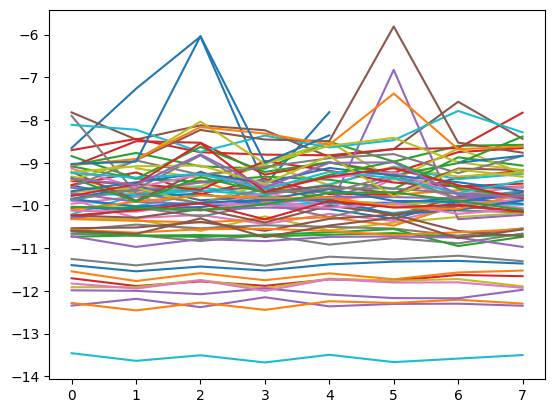

In [27]:
stds, df = plot_aperture_phot_on_list(imgs, imgs, bright_ref_cat_crds)

Text(0, 0.5, 'Std dev (FORCED_APER)')

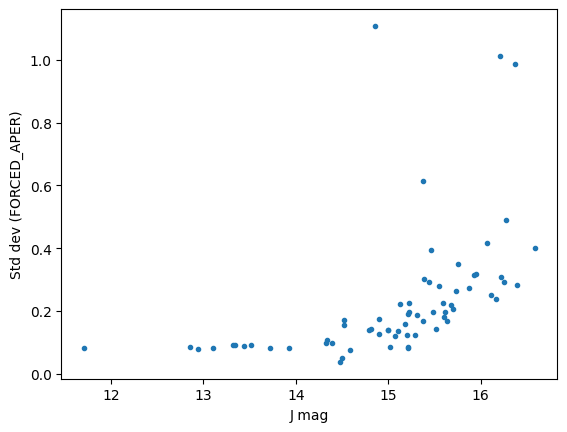

In [28]:
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (FORCED_APER)')

In [29]:
df

,id,xcenter,ycenter,aperture_sum,image,astrometry_image
0,1,1826.996955,139.911784,2894.450296,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
1,2,1763.429019,550.276463,0.000000,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
2,3,1762.405339,409.810234,0.000000,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
3,4,1719.173770,355.834775,3370.634677,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
4,5,1705.566765,652.176028,14381.358071,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
...,...,...,...,...,...,...
603,72,463.575528,442.266856,16631.329028,WINTERcamera_20250221-073341-459_mef_4_0_0.fits,WINTERcamera_20250221-073341-459_mef_4_0_0.fits
604,73,444.846839,42.452648,11000.751110,WINTERcamera_20250221-073341-459_mef_4_0_0.fits,WINTERcamera_20250221-073341-459_mef_4_0_0.fits
605,74,296.791606,283.506859,8575.217672,WINTERcamera_20250221-073341-459_mef_4_0_0.fits,WINTERcamera_20250221-073341-459_mef_4_0_0.fits
606,75,292.716476,557.021186,8287.858892,WINTERcamera_20250221-073341-459_mef_4_0_0.fits,WINTERcamera_20250221-073341-459_mef_4_0_0.fits


/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **

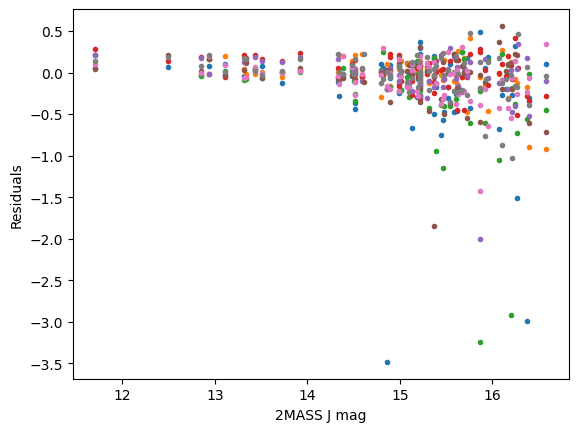

In [30]:
list(all_xmatch.keys())

res_df_forced = []

for key, (cat, ref) in all_xmatch.items():
    name = str(Path(key).with_suffix(".fits"))

    mask = df["image"] == name
    
    mags = -2.5 * np.log10(df["aperture_sum"][mask])

    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(mags, bright_ref_cat['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = bright_ref_cat['j_m'] - mags - zp
    plt.plot(bright_ref_cat['j_m'], residuals, '.')
    res_df_forced.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars,
    })

res_df_forced = pd.DataFrame(res_df_forced)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_forced.pdf")

Median: -0.02, std: 0.38 
 ZP: 25.11, zpstd 0.05, nstars: 256


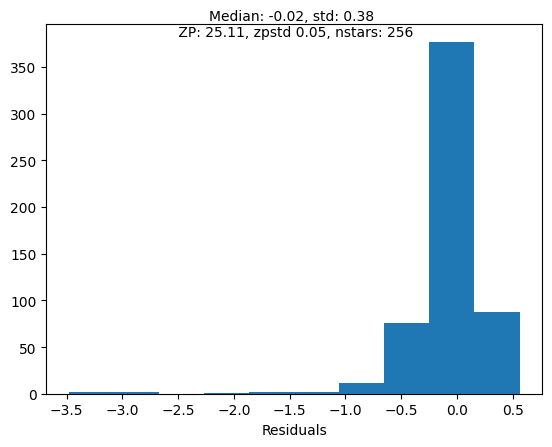

In [31]:
all_residuals = [x for y in res_df_forced["residuals"] for x in y if pd.notnull(x) & np.isfinite(x)]
plt.hist(all_residuals)
txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_forced["zp"].median():.2f}, zpstd {res_df_forced["zpstd"].median():.2f}, nstars: {res_df_forced["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_forced.pdf",
    bbox_inches="tight",
)

In [32]:
# results = dict()
# results[